<a href="https://colab.research.google.com/github/DIFACQUIM/Cursos/blob/main/4_Espacio_Qu%C3%ADmico_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis de componentes principales (PCA)


---
Realizó: Ana Chávez, Fernanda Saldívar, Armando Rufino y Hector Ortíz

Contacto: anachavez3026@gmail.com, fer.saldivarg@gmail.com

In [ ]:
from IPython.utils import io
import tqdm.notebook
import os, sys, random 
total = 100
with tqdm.notebook.tqdm(total=total) as pbar:
    with io.capture_output() as captured:
      # Instalar rdkit
      !pip -q install rdkit.pypi==2021.9.4
      pbar.update(20)
      # Instalar Pillow
      !pip -q install Pillow
      pbar.update(40)
      # Instalar molplotly
      !pip install molplotly
      pbar.update(60)
      # Instalar jupyter-dash
      !pip install jupyter-dash
      pbar.update(80)
      # Instalar el diseño de aplicación dash
      !pip install dash-bootstrap-components
      pbar.update(100)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import dash_bootstrap_components as dbc 
from sys import argv

from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors

* RDKIT: https://www.rdkit.org/docs/GettingStartedInPython.html
* PANDAS: https://pandas.pydata.org/
* NUMPY: https://numpy.org/
* SKLEARN: https://scikit-learn.org/stable/

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Leer bases de datos
#BIOFACQUIM
url_biofacquim = "https://raw.githubusercontent.com/DIFACQUIM/Cursos/main/Pre-simposio%20QF/Espacio_quimico/Datasets/BIOFACQUIM.V2_curada.csv"
BIOFACQUIM = pd.read_csv(url_biofacquim)
print(BIOFACQUIM.head(2))

        ID                                             SMILES    Data set
0  FQNP502       c1cc2c(cc1C1OCC3C(c4ccc5c(c4)OCO5)OCC13)OCO2  BIOFACQUIM
1  FQNP281  C=C(C)C(C)(C)CCC(C)C1CCC2(C)C3CCC4C(C)(C)C5CCC...  BIOFACQUIM


In [ ]:
# Leer bases de datos

#FDA
url_fda = "https://raw.githubusercontent.com/DIFACQUIM/Cursos/main/Pre-simposio%20QF/Espacio_quimico/Datasets/FDA_2022_july_05_curada.csv"
FDA = pd.read_csv(url_fda)
FDA.head(2)

,ID,SMILES,NEW_SMILES,Data set
0,DB00006,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@...,CCC(C)C(NC(=O)C(CCC(=O)O)NC(=O)C(CCC(=O)O)NC(=...,FDA
1,DB00007,CCNC(=O)[C@@H]1CCCN1C(=O)[C@H](CCCNC(N)=N)NC(=...,CCNC(=O)C1CCCN1C(=O)C(CCCN=C(N)N)NC(=O)C(CC(C)...,FDA


In [ ]:
# Leer base de datos
#DNMT1
url_dnmt1 = "https://raw.githubusercontent.com/DIFACQUIM/Cursos/main/Pre-simposio%20QF/Espacio_quimico/Datasets/DNMT1_curada.csv"
DNMT1 = pd.read_csv(url_dnmt1)
DNMT1.head(2)

,ID,SMILES,Data set
0,"""CHEMBL2336409",Cc1cc(=Nc2ccc(NC(=O)c3ccc(N=c4cc[nH]c5ccccc45)...,DNMT1
1,"""CHEMBL1361703",COc1ccccc1CNC(=O)COC(=O)c1cc(-c2ccco2)nc2ccccc12,DNMT1


In [ ]:
# Ejemplo de smiles
smi = list(FDA["NEW_SMILES"])[15]
print(smi)

NC(Cc1ccccc1)C(=O)O


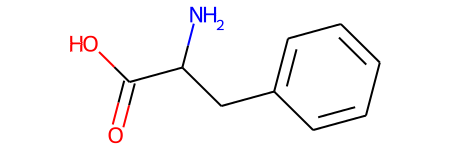

In [ ]:
# Ejemplo de una molécula
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage
mol = Chem.MolFromSmiles(smi)
mol

In [ ]:
# Ver columnas
print(FDA.columns)
print(BIOFACQUIM.columns)
print(DNMT1.columns)

Index(['ID', 'SMILES', 'NEW_SMILES', 'Data set'], dtype='object')
Index(['ID', 'SMILES', 'Data set'], dtype='object')
Index(['ID', 'SMILES', 'Data set'], dtype='object')


In [ ]:
# Seleccionar columnas
FDA = FDA[['ID', 'NEW_SMILES', "Data set"]]
BIOFACQUIM = BIOFACQUIM[['ID', 'SMILES', "Data set"]]
DNMT1 = DNMT1[['ID', 'SMILES', "Data set"]]
# Cambiar nombre a columnas
FDA.columns = ["ID", "SMILES", "Data set"]
BIOFACQUIM.columns = ['ID',  'SMILES', "Data set"]
DNMT1.columns = ["ID", "SMILES", "Data set"]
FDA.head(2)

,ID,SMILES,Data set
0,DB00006,CCC(C)C(NC(=O)C(CCC(=O)O)NC(=O)C(CCC(=O)O)NC(=...,FDA
1,DB00007,CCNC(=O)C1CCCN1C(=O)C(CCCN=C(N)N)NC(=O)C(CC(C)...,FDA


In [ ]:
# Unir (concatenar) bases de datos
DATA = pd.concat([FDA, BIOFACQUIM, DNMT1], axis=0).reset_index(drop=True)
DATA.head(2)

,ID,SMILES,Data set
0,DB00006,CCC(C)C(NC(=O)C(CCC(=O)O)NC(=O)C(CCC(=O)O)NC(=...,FDA
1,DB00007,CCNC(=O)C1CCCN1C(=O)C(CCCN=C(N)N)NC(=O)C(CC(C)...,FDA


In [ ]:
# Generar descriptores
DATA["HBA"] = [Descriptors.NumHAcceptors(y) for y in (Chem.MolFromSmiles(x) for x in DATA["SMILES"])]
DATA["HBD"] = [Descriptors.NumHDonors(y) for y in (Chem.MolFromSmiles(x) for x in DATA["SMILES"])]
DATA["RB"] = [Descriptors.NumRotatableBonds(y) for y in (Chem.MolFromSmiles(x) for x in DATA["SMILES"])]
DATA["LogP"] = [Descriptors.MolLogP(y) for y in (Chem.MolFromSmiles(x) for x in DATA["SMILES"])]
DATA["TPSA"] = [Descriptors.TPSA(y) for y in (Chem.MolFromSmiles(x) for x in DATA["SMILES"])]
DATA["MW"] = [Descriptors.MolWt(y) for y in (Chem.MolFromSmiles(x) for x in DATA["SMILES"])]

In [ ]:
DATA.head(2)

,ID,SMILES,Data set,HBA,HBD,RB,LogP,TPSA,MW
0,DB00006,CCC(C)C(NC(=O)C(CCC(=O)O)NC(=O)C(CCC(=O)O)NC(=...,FDA,29,27,66,-8.3261,904.07,2180.317
1,DB00007,CCNC(=O)C1CCCN1C(=O)C(CCCN=C(N)N)NC(=O)C(CC(C)...,FDA,14,15,32,-1.4381,431.54,1209.421


In [ ]:
# Guardar base de datos
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)
#DATA.to_csv("/content/drive/MyDrive/Pre-simposio QF/4.Espacio_quimico/Dataset.csv", sep=",", index=False)

In [ ]:
dataset = DATA[["Data set", "HBA", "HBD", "RB", "LogP", "TPSA", "MW"]]
dataset.head(2)

,Data set,HBA,HBD,RB,LogP,TPSA,MW
0,FDA,29,27,66,-8.3261,904.07,2180.317
1,FDA,14,15,32,-1.4381,431.54,1209.421


### Generar PCA

#### 1. Dividir base de datos

In [ ]:
#Dividir matriz
data = dataset.iloc[:,1:7].values # Seleccionar columnas con descriptores
label = dataset.iloc[:,0].values # Seleccionar el nombre de la base de datos(label) de las columnas

In [ ]:
pd.DataFrame(data).head(2)

,0,1,2,3,4,5
0,29.0,27.0,66.0,-8.3261,904.07,2180.317
1,14.0,15.0,32.0,-1.4381,431.54,1209.421


#### 2. Normalizar datos
StandardScaler() estandariza las características del conjunto de datos en la escala de la unidad (media = 0 y varianza = 1) que es un requisito para el rendimiento óptimo de muchos algoritmos de aprendizaje automático.

In [ ]:
# Normalizar datos
from sklearn.preprocessing import StandardScaler
data_std = StandardScaler().fit_transform(data)

#### 3. Entrenar modelo

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_results = pca.fit_transform(data_std)
pca_results

array([[12.26627542, -0.2688375 ],
       [ 5.31202868, -0.27711511],
       [ 6.01725051,  0.20258812],
       ...,
       [ 0.30254128, -1.56406378],
       [ 0.22145159, -1.34390233],
       [ 0.03151497, -0.65994966]])

In [ ]:
# Seleccionar impormación complementaria
label = DATA[["Data set", "ID", "SMILES"]]
label = label.to_numpy()

In [ ]:
# Concatenar arrays de numpy
arr = np.concatenate((label, pca_results), axis = 1)
# Crear un nuevo dataframe
pca_dataset = pd.DataFrame(data=arr, columns = ['Data set',"ID", "SMILES",'component1', 'component2'])
pca_dataset.head(2)

,Data set,ID,SMILES,component1,component2
0,FDA,DB00006,CCC(C)C(NC(=O)C(CCC(=O)O)NC(=O)C(CCC(=O)O)NC(=...,12.266275,-0.268838
1,FDA,DB00007,CCNC(=O)C1CCCN1C(=O)C(CCCN=C(N)N)NC(=O)C(CC(C)...,5.312029,-0.277115


Al realizar el método de PCA, hay una pérdida de correlación con cada componente, por esto es necesario poder identificar la cantidad de correlación que poseemos para nuestras representaciones visuales, pudiendo determinar si estas serán relevantes o no por la cantidad de correlación que posean con la muestra original.

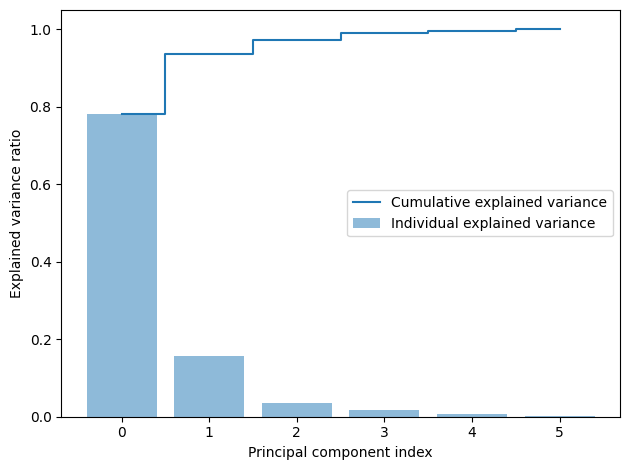

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(data)
X_train_std = sc.transform(data)
#X_test_std = sc.transform(X_test)
# Instantiate PCA
pca = PCA()

# Determine transformed features
X_train_pca = pca.fit_transform(X_train_std)

# Determine explained variance using explained_variance_ration_ attribute
exp_var_pca = pca.explained_variance_ratio_
#
# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
#
# Create the visualization plot
import matplotlib.pyplot as plt
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

Ahora vamos a usar **seaborn** para hacer el gráfico de PCA. En este gráfico, los puntos de datos similares deberían estar más cerca, formando clusters. Para este conjunto de datos nos gustaría ver a las distintas bases de datos, formando grupos distintos.
(Al hacer el gráfico de dispersión, el parámetro `DataBase` se corresponde con el color de los puntos).

In [ ]:
pca_dataset.head(2)

,Data set,ID,SMILES,component1,component2
0,FDA,DB00006,CCC(C)C(NC(=O)C(CCC(=O)O)NC(=O)C(CCC(=O)O)NC(=...,12.266275,-0.268838
1,FDA,DB00007,CCNC(=O)C1CCCN1C(=O)C(CCCN=C(N)N)NC(=O)C(CC(C)...,5.312029,-0.277115


In [ ]:
#Graficar
import plotly.express as px
import molplotly
fig_pca = px.scatter(pca_dataset,
                            x='component1',
                            y='component2',
                            #symbol='Minimum Degree',
                            color='Data set',
                            color_discrete_sequence=["indigo", "green", 'orange',],
                            title='PCA',
                            labels={'PC1': 'PC_1',
                                    'PC2': 'PC_2'},
                            width=700,
                            height=500)
app_marker = molplotly.add_molecules(fig=fig_pca,
                                         df=pca_dataset,
                                         smiles_col='SMILES',
                                         title_col='ID',
                                         color_col='Data set'
                                        )

app_marker.run_server(mode='inline', port=8801, height=1000)

Dash is running on http://127.0.0.1:8801/



/usr/local/lib/python3.10/dist-packages/molplotly/main.py:78: FutureWarning:

In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.

INFO:dash.dash:Dash is running on http://127.0.0.1:8801/



<IPython.core.display.Javascript object>

In [ ]:
#============================================================================#

## Para saber más:
 
* Medina-Franco JL, Sánchez-Cruz N, López-López E, Díaz-Eufracio BI. Progress on open chemoinformatic tools for expanding and exploring the chemical space. J Comput Aided Mol Des. 2022, 36, 341-354. DOI: [10.1007/s10822-021-00399-1](https://link.springer.com/article/10.1007/s10822-021-00399-1).
* Medina-Franco JL, Chávez-Hernández AL, López-López E, Saldívar-González FI. Chemical Multiverse: An Expanded View of Chemical Space. Mol Inform. 2022, 41, e2200116. DOI: [10.1002/minf.202200116](https://onlinelibrary.wiley.com/doi/10.1002/minf.202200116). 
* Greener JG, Kandathil SM, Moffat L, Jones DT. A guide to machine learning for biologists. Nat Rev Mol Cell Biol. 2022, 23, 40-55. DOI:[10.1038/s41580-021-00407-0](https://www.nature.com/articles/s41580-021-00407-0).
* Bender A, Schneider N, Segler M, Patrick Walters W, Engkvist O, Rodrigues T. Evaluation guidelines for machine learning tools in the chemical sciences. Nat Rev Chem. 2022, 6, 428-442. DOI: [10.1038/s41570-022-00391-9](https://www.nature.com/articles/s41570-022-00391-9).